In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

from entities_recognition.bilstm.train import trainIters, evaluate_all
from common.utils import wordpunct_space_tokenize
from config import START_TAG, STOP_TAG

In [2]:
TRAIN_PATH = path.join(BASE_PATH, 'data/CoNLL-2003/eng.train')
print(TRAIN_PATH)

/Users/2359media/Documents/botbot-nlp/data/CoNLL-2003/eng.train


In [3]:
import io
import string

def read_conll_2003(filename):
    all_data = []

    current_txt = []
    current_tags = []
    tagset = []

    fin = io.open(filename, 'r', encoding='utf-8', newline='\n', errors='ignore')
    for line in fin:
        line = line.strip()
        if len(line) > 0: # skip blank lines
            tmp = line.split(' ')
            if tmp[0] != '-DOCSTART-':
                current_txt.append(tmp[0])
                current_tags.append(tmp[-1])
                tagset.append(tmp[-1])
        else:
            if len(current_txt) > 0:
                line_txt = ''
                line_tags = []
                for idx in range(len(current_txt)):
                    tokens = wordpunct_space_tokenize(current_txt[idx])
                    if idx > 0:
                        line_txt += ' ' + current_txt[idx]
                        if current_tags[idx - 1] == current_tags[idx]:
                            line_tags.extend([current_tags[idx]] * (1 + len(tokens)))
                        else:
                            line_tags.append('O')
                            line_tags.extend([current_tags[idx]] * len(tokens))
                    else:
                        line_txt += current_txt[idx]
                        line_tags.extend([current_tags[idx]] * len(tokens))
                all_data.append((line_txt, ' '.join(line_tags)))
                current_txt = []
                current_tags = []
    fin.close()

    tagset = list(set(tagset))
    tag_to_ix = {tag: key for key, tag in enumerate(tagset)}
    tag_to_ix[START_TAG] = len(tagset)
    tag_to_ix[STOP_TAG] = len(tagset) + 1

    print(tag_to_ix)
    print('Loaded %s sentences' % len(all_data))
    
    return tag_to_ix, all_data

In [4]:
from entities_recognition.bilstm.predict import read_tags

tag_to_ix, training_data = read_conll_2003(TRAIN_PATH)
result = []
for sentence, tag_seq in training_data:
    tokens_in = wordpunct_space_tokenize(sentence)
    assert len(tokens_in) == len(tag_seq.split(' '))
#     print(read_tags(tokens_in, tag_seq.split(' ')))

{'I-LOC': 0, 'I-MISC': 1, 'B-MISC': 2, 'I-PER': 3, 'B-LOC': 4, 'B-ORG': 5, 'I-ORG': 6, 'O': 7, '<START>': 8, '<STOP>': 9}
Loaded 14041 sentences


Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
90m 35s (- 815m 20s) (1 10%) 48895.7656
194m 32s (- 778m 11s) (2 20%) 28399.0879
300m 32s (- 701m 16s) (3 30%) 24982.8691
432m 3s (- 648m 5s) (4 40%) 23229.8184
603m 51s (- 603m 51s) (5 50%) 23681.2246
691m 28s (- 460m 58s) (6 60%) 22176.2363
779m 24s (- 334m 1s) (7 70%) 20797.1016
867m 21s (- 216m 50s) (8 80%) 20974.9219
955m 2s (- 106m 6s) (9 90%) 21373.9414
1051m 56s (- 0m 0s) (10 100%) 20812.8848


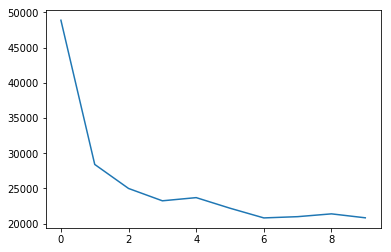

In [5]:
losses, model = trainIters(training_data, 
                           tag_to_ix,
                           learning_rate=1e-3,
                           n_iters=10, 
                           log_every=1,
                           verbose=1)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

In [6]:
import torch
model.eval()
torch.save(model.state_dict(), 'bilstm-rnn-conll2003.bin')

In [7]:
evaluate_all(model, training_data, tag_to_ix)

0.966161264295992

In [8]:
TEST_PATH_A = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testa')
TEST_PATH_B = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testb')
_, testing_data_a = read_conll_2003(TEST_PATH_A)
_, testing_data_b = read_conll_2003(TEST_PATH_B)

{'I-LOC': 0, 'I-MISC': 1, 'B-MISC': 2, 'I-PER': 3, 'I-ORG': 4, 'O': 5, '<START>': 6, '<STOP>': 7}
Loaded 3250 sentences
{'I-LOC': 0, 'I-MISC': 1, 'B-MISC': 2, 'I-PER': 3, 'B-LOC': 4, 'B-ORG': 5, 'I-ORG': 6, 'O': 7, '<START>': 8, '<STOP>': 9}
Loaded 3453 sentences


In [9]:
evaluate_all(model, testing_data_a, tag_to_ix)

0.9671552197542086

In [10]:
evaluate_all(model, testing_data_b, tag_to_ix)

0.9614279723212413

In [11]:
from entities_recognition.bilstm.predict import predict
test_data = [
    'I live in Ho Chi Minh City, nice place, though my hometown is in Hanoi. I do miss it sometimes',
    'Trump’s role in midterm elections roils Republicans',
    'Kenya bans film about 2 girls in love because it’s ‘too hopeful’',
    'G.O.P. leaders and White House aides are trying to prepare President Trump for trouble in House and Senate races.'
]
predict(model, test_data, tag_to_ix)

Raw predicted tags:
[7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1]
[1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7]


[{'LOC': ['Ho Chi Minh City', 'Hanoi.']},
 {'MISC': ['Trump’s', 'Republicans']},
 {'MISC': ['Kenya']},
 {'MISC': ['Trump'],
  'ORG': ['G.O.P.', 'House and Senate'],
  'PER': ['White House']}]